# ECE532 Final Project: Clustering Congressional Districts

### Group Members: Michael Hickey, Thomas Hillebrand, Ryan Milanowski

# 1) Abstract

# 2) Background/Warm Up

# 3) Sample Dataset: Review of Clustering Algorithms

The algorithms included in this assignment will be coded using the R programming language. First, we must load our libraries:

In [1]:
library(dplyr)
library(ggplot2)
library(magrittr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



To run the mean shift algorithm, some libraries are required that are not available in the standard environment.  We will recreate those libraries using the following code block.  This is a lot of code, but do not worry.  We'll go through the applicable functions and their usage in the exercises below.

In [3]:
blurringMeanShiftOperator <- function( X, h=1, kernel="epanechnikovKernel" ){
	
	n.curves <- ncol( X )
	
	## compute distances
	distances <- as.matrix( dist( t( X ), diag=TRUE, upper=TRUE ) )
	
	## scale by bandwidth
	scaled.distances <- distances / h
	
	## evaluate kernel
	kernel <- get( kernel )
	kernel.values <- matrix( kernel( scaled.distances ), nrow=n.curves,
	ncol=n.curves ) 
	
	## weights denominators
	total.sum <- colSums( kernel.values )
	
	## weights
	kernel.weights <- kernel.values / total.sum

	## update
	new.X <- X%*%t( kernel.weights )
	
	output <- new.X
	
	return( new.X )
	
}

blurringMeanShiftAlgorithm <- function( X, h=NULL,
kernel="epanechnikovKernel", tol.stop=1e-6, max.iter=100 ){
	
	if( is.null( h ) ){
		
		h <- quantile( dist( t( X ) ), 0.3 )
		
	}
	
	close.enough <- FALSE
	
	old.X <- X
	
	iter <- 0
	not.converged <- FALSE
	
	## while the largest update corresponds to a shift
	## larger than 'tol.stop' and while number of iterations
	## is smaller than 'max.iter'
	while( !close.enough ){
		
		## apply blurring mean-shift operator and update
		iter <- iter + 1
		
		new.X <- blurringMeanShiftOperator( X=old.X, h=h, kernel=kernel )
		
		distance <- max( sqrt( colSums( old.X - new.X )^2 ) )
		
		old.X <- new.X
		
		close.enough <- ( distance < tol.stop )
		
		if( iter >= max.iter ){
			
			not.converged <- TRUE
			break
			
		}
		
	}
	
	if( not.converged ){
		
		if( kernel == "epanechnikovKernel"){
			
			warning( "Reached maximum number of iterations (", 
			as.character( max.iter),"). The algorithm ",
			"didn't converge. Try increasing max.iter." )
			
		} else{

			warning( "Reached maximum number of iterations (", 
			as.character( max.iter),"). The algorithm ",
			"didn't converge. Try kernel=\"epanechnikovKernel\"." )
			
		}
		
	} else{

		message( "Blurring mean-shift algorithm ran successfully.\n")
			
	}
	
	return( new.X )
	
}

bmsClustering <- function( X, h=NULL, kernel="epanechnikovKernel",
tol.stop=1e-6, max.iter=100, tol.epsilon=1e-3 ){
	
	# minimal input checking
	X <- as.matrix( X )
	max.iter <- as.integer( max.iter )
	
	if( ncol( X ) <= 1 ){
		
		message( "The input matrix X has only one column: ",
		"returning input.")
		return( X )
	}

	if( !is.element( kernel, paste( c( "epanechnikov", "cubic", 
	"gaussian", "exponential"), "Kernel", sep="" ) ) ){
		
		stop( "Invalid kernel name.")
		
	}
	
	if( !is.null( h ) && h <= 0 ){
		
		stop( "The bandwidth must be strictly positive." )
				
	}
	
	if( max.iter <= 0 ){
		
		stop( "The maximum number of iterations must be a positive ",
		"integer." )
		
	}
	
	if( tol.stop <= 0 || tol.epsilon <= 0 ){
		
		stop( "All tolerances must be strictly positive.")
		
	}
	
	## run blurring mean-shift algorithm
	message( "\nRunning blurring mean-shift algorithm...\n" )
	
	blurring.mean.shift.algorithm <- blurringMeanShiftAlgorithm( X=X,
	h=h, kernel=kernel, tol.stop=tol.stop, max.iter=max.iter )
	
	## find connected components
	message( "Finding clusters..." )
	output <- connectedComponents( X=blurring.mean.shift.algorithm,
	tol.epsilon=tol.epsilon )
	
	invisible( output )

}


gaussianKernel <- function( x ){
	
	## function to evaluate the asymmetric gaussian kernel	
	computeGaussianKernel <- function( y ){
	
		if( 0 <= y ){
		
			value <- 2 / 0.388 * dnorm( y / 0.388 )
		
		} else{
		
			value <- 0
		
		}
	
		return( value )
	
	}
	
	output <- sapply( x, computeGaussianKernel )
	
	return( output )
		
}


###

exponentialKernel <- function( x ){
	
	## function to evaluate the asymmetric exponential kernel	
	computeExponentialKernel <- function( y ){
	
		if( 0 <= y ){
		
			value <- dexp( y, rate=4.61 )
		
		} else{
		
			value <- 0
		
		}
	
		return( value )
	
	}
	
	output <- sapply( x, computeExponentialKernel )
	
	return( output )
		
}

###

cubicKernel <- function( x ){
	
	## function to evaluate the asymmetric cubic kernel	
	computeCubicKernel <- function( y ){
	
		if( 0 <= y && y<= 1 ){
		
			value <- 4 * ( 1 - y )^3
		
		} else{
		
			value <- 0
		
		}
	
		return( value )
	
	}
	
	output <- sapply( x, computeCubicKernel )
	
	return( output )
		
}

###

epanechnikovKernel <- function( x ){
	
	## function to evaluate the asymmetric Epanechnikov kernel	
	computeEpanechnikovKernel <- function( y ){
	
		if( 0 <= y && y<= 1 ){
		
			value <- 3 / 2 * ( 1 - y^2 )
		
		} else{
		
			value <- 0
		
		}
	
		return( value )
	
	}
	
	output <- sapply( x, computeEpanechnikovKernel )
	
	return( output )
		
}

###

distanceFunction <- function( x, y ){
	
	## function to compute the standard euclidean distance
	output <- sqrt( sum( ( x - y )^2 ) )
	
	return( output )
	
}

###

connectedComponents <- function( X, tol.epsilon=1e-3 ){

	N <- ncol( X )
	
	## initialize components matrix
	C <- X
	
	## initialize components vector
	labels <- vector( mode="integer", length=N )
	
	K <- 1 
	labels[1] <- 1
	C[,1] <- X[,1]
	
	# pb <- txtProgressBar( min=0, max=N, style=3 )
	
	## efficient connected component algorithm
	for( n in 2:N ){
		
		assigned <- FALSE
				
		for( k in 1:K ){
			
			distance <- distanceFunction( X[,n], C[,k] )
			
			if( distance < tol.epsilon ){
				
				labels[n] <- k
				assigned <- TRUE
				break
				
			}
			
		}
		
		if( !assigned ){
			
			K <- K + 1
			labels[n] <- K
			C[,K] <- X[,n]
			
		}
		
		# setTxtProgressBar( pb, n )
		
	}
	
	C <- as.matrix( C[,1:K] )
	colnames( C ) <- paste( "mode", 1:K, sep="" )
	
	labels <- as.integer( labels )
	
	output <- list( components=C, labels=labels )
	
	# close( pb )
	
	message( "\nThe algorithm found ", as.character( K ),
	" clusters.\n")
	
	return( output )
		
}

Before clustering for the Congressional district application, we will practice on small scale example data.

`iris` is the name of a sample data set built into the R program. We can compare values of sepal and petal sizes of different species

In [4]:
head(iris) # Return first 6 rows of iris data set

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


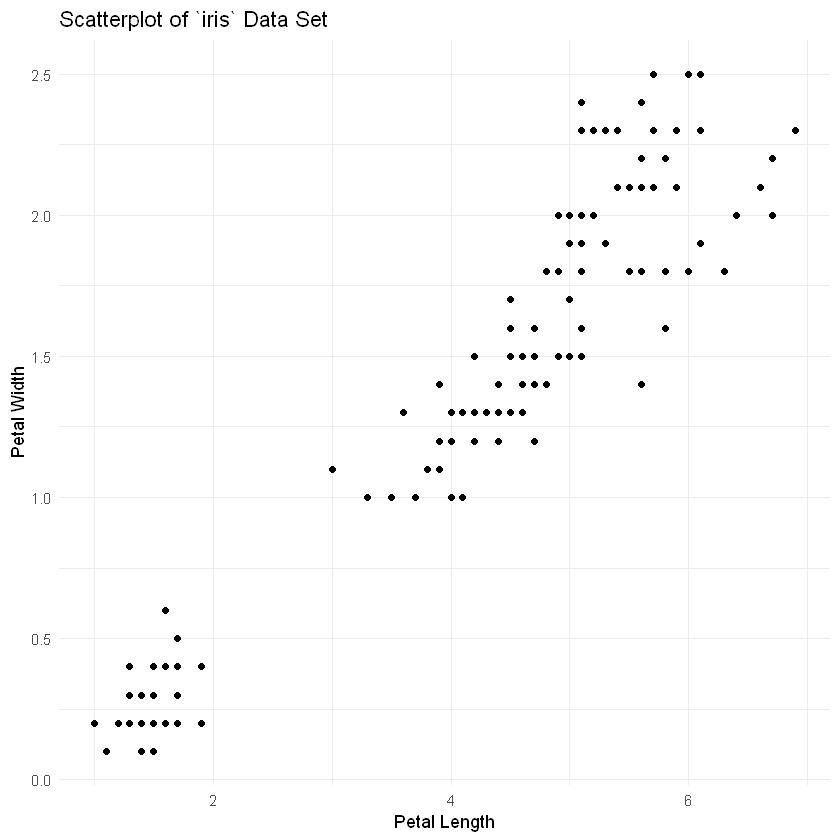

In [5]:
# Generate scatter plot of two columns of the `iris` data set
ggplot(iris) +
    geom_point(aes(x = Petal.Length, y = Petal.Width)) +
    labs(x = "Petal Length", y = "Petal Width", title = "Scatterplot of `iris` Data Set") +
    theme_minimal()

There appear to be at least 2 natural clusters in the data. We will apply both the K-Means and Mean Shift clustering algorithms to automatically determine clusters.

## 3.1) K-Means Clustering Algorithm

The first step is to scale the data. 

In many clustering applications, different variables are defined on scales that are difficult to compare (e.g. weight and distance, etc). However, most clustering algorithms work by comparing the Euclidean distance between points (the square root of sum of squares of each single-dimensional distance). If one clustering parameter is defined on a scale that is arbitrarily larger than another clustering parameter, then the clustering results will be skewed to care more about the first parameter. For example, if two clustering parameters are annual salary ($) and age (years), then the resulting clusters will largely ignore any differences in age which are much smaller than differences in salary.

To account for unbalances in parameter scales, a useful practice to apply before clustering data is to scale and center the parameters. In many cases it is useful to subtract each parameter value by its mean value (setting the new mean to zero), and dividing by the parameter's standard deviation (setting the new standard deviation to 1).

This practice is applied in the example below:

In [8]:
# We only need the two columns of data that we will be clustering
TestData <- iris %>% transmute(Petal.Length, Petal.Width)

# Scaling Data such that mean = 0, and sd = 1
TestData$Petal.Length <- (TestData$Petal.Length-mean(TestData$Petal.Length))/sd(TestData$Petal.Length)
TestData$Petal.Width <- (TestData$Petal.Width-mean(TestData$Petal.Width))/sd(TestData$Petal.Width)


In R, the `kmeans()` function requires three inputs:

- The clustering data set
- The specified number of clusters, `K`
- The maximum number of iterations allowed, `iter.max` (this will only be reached if convergence is not achieved)

Note that the initial cluster centers are randomly determined by the `kmeans()` function, unless they are specified. In this exercise, we will set a random seed `set.seed(0)` to ensure the initial cluster centers are always the same when this code is run.

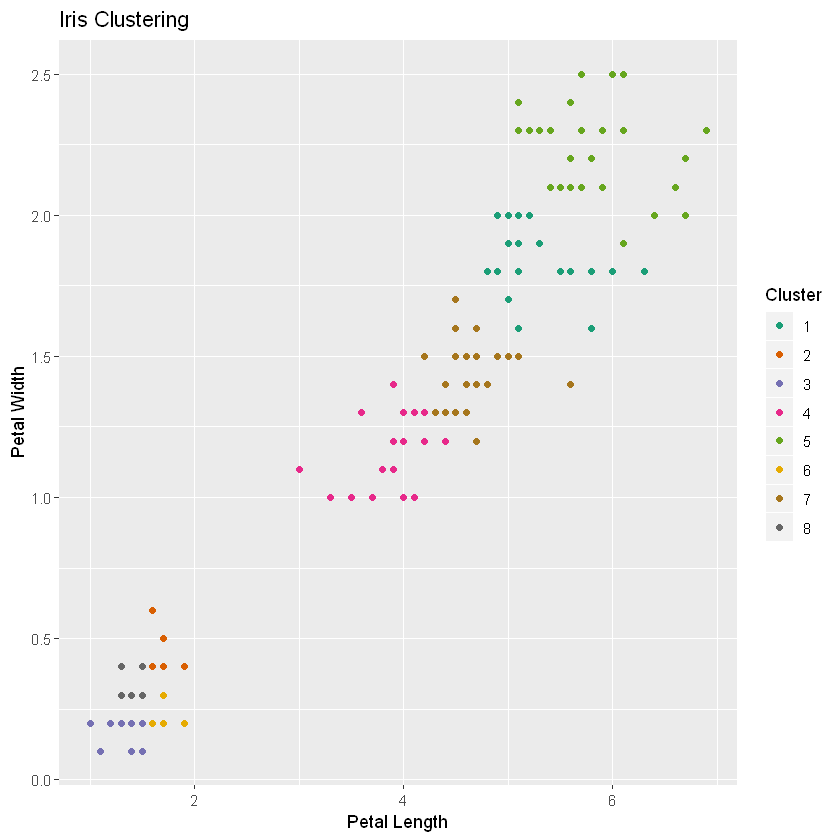

In [9]:
# Set Parameters
K <- 8            # Number of K-Means clusters
set.seed(25)       # Random seed (This allows for repeatable results)
iter.max <- 10     # Maximum number of kmeans iterations

# Apply K-Means Clustering
clust <- kmeans(TestData, centers = K, iter.max = iter.max)

PlotTestData <- iris
PlotTestData$cluster <- as.factor(clust$cluster)

ggplot(PlotTestData) +
    geom_point(aes(x = Petal.Length, y = Petal.Width, color = cluster)) +
    labs(x = "Petal Length", y = "Petal Width", title = "Iris Clustering",
         color = "Cluster") + 
    scale_color_brewer(palette = "Dark2")

### Activity 2: Examing the Effects of K-Means Input Parameters

Use the above code block to alter inputs and re-generate the plot. Only the three lines under the comment `# Set Parameters` will need to be changed.

#### Question 2. a)
Ensure the following parameters are specified, and run the code chunk above: `K <- 2`, `set.seed(0)`, and `iter.max <- 10`. 

- Are the resulting clusters logical (i.e. do they appear to accurately represent clusters in the data)?
- Are the resulting clusters the same size (number of data points) as one another? Why or why not?

#### Question 2. b)
Ensure the following parameters are specified, and run the code chunk above: `K <- 8`, `set.seed(0)`, and `iter.max <- 2`. 

- Does the K-Means clustering algorithm converge on a solution?
- Try increasing the `iter.max` parameter. How many iterations are needed to converge on a solution?
- On a large data set, with many rows and columns, why might it be beneficial to limit the number of iterations?


#### Question 2. c)
Reset the following parameters are specified, and run the code chunk above: `K <- 8`, `set.seed(0)`, and `iter.max <- 10`. 

- Now reset the random seed as `set.seed(2)`. This will effectively results in a different set of initial cluster centers. Do the results change? 
- Try several different random seeds. Do the results always converge on the same solution?


## 3.2) Mean Shift Clustering Algorithm

We will utilize the same scaled data as created for the K-means algorithm.

In R there are several mean shift algorithms available.  We'll be utilizing one we recreated from a package called MeanShift.  Within this package there are 2 different mean shift algorthims, a standard and a "blurred" version, which approximates the standard mean shift algorithm. Because it recursively updates the entire sample at each iteration, the blurring version of the mean shift algorithm is often faster than the standard version (especially if the standard mean shift algorithm is run using a single core).

For speed purposes, we'll be using the blurring mean shift algorithm

The bmsClustering() function requires five inputs:

- The clustering data set
- The bandwidth
- The kernal function - The following kernels are supported:Epanechnikov, cubic, Gaussian, exponential
- A stop tolerance - The mean shift algorithm stops when its update generates a step of length smaller than tol.stop. tol.stop should be considerably smaller than tol.epsilon.
- The maximum number of iterations allowed, iter.max (this will only be reached if convergence is not achieved)
- An epsilon tolerance - Points that are less than tol.epsilon- separated are grouped in the same cluster once the algorithm stops.


Running blurring mean-shift algorithm...

Blurring mean-shift algorithm ran successfully.

Finding clusters...

The algorithm found 2 clusters.



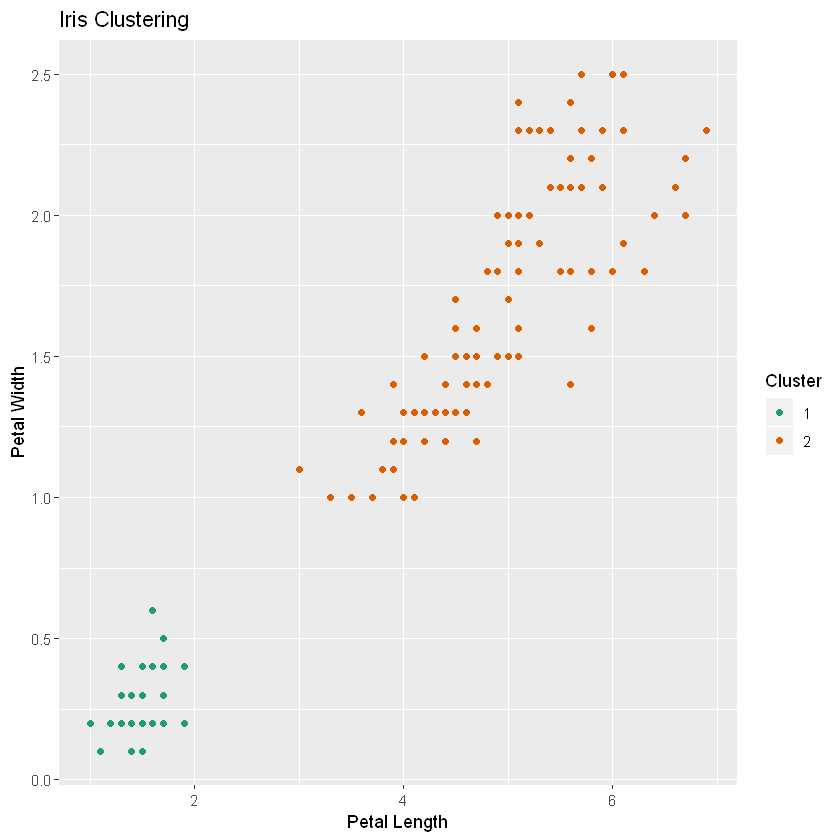

In [10]:
# Set Parameters
X <- t(TestData)  #The data requires a data set with the points in each column
h <- .8 # the bandwidth parameter
kernel <- "epanechnikovKernel" # The kernal can be "epanechnikovKernel", "cubicKernel", "gaussianKernel", "exponentialKernel"
tol.stop <- 1e-6    # Stop tolerance
tol.epsilon <- 1e-04  # Eplison tolerance
max.iter <- 100  # Maximum number of meanshift iterations

# Apply MeanShift Clustering
clust_ms <- bmsClustering(X = X,
                         h=h,
                         kernel = kernel,
                         tol.stop = tol.stop,
                         tol.epsilon = tol.epsilon,
                         max.iter = max.iter)

PlotTestDataMS <- iris
PlotTestDataMS$cluster <- as.factor(clust_ms$labels)

ggplot(PlotTestDataMS) +
    geom_point(aes(x = Petal.Length, y = Petal.Width, color = cluster)) +
    labs(x = "Petal Length", y = "Petal Width", title = "Iris Clustering",
         color = "Cluster") + 
    scale_color_brewer(palette = "Dark2")

# 4) Clustering Applications for Drawing Congressional Districts

The data we will be clustering is from the US Census Bureau (https://www.census.gov/geographies/reference-files/time-series/geo/centers-population.html). It represents the distribution of Census Tracts in the state of Wisconsin. For the purposes of this assignment, we can make the simplifying assumption that each Census tract is associated with an equal population size. While this assumption is inaccurate, it sufficiently reduces the data size and computational time to allow for a reasonable timeframe for completing the assignment.

In [11]:
Data <- read.csv("Wisconsin.csv")
head(Data, 5) # Preview first 8 rows of data
print(paste0("Data consists of ", nrow(Data), " unique Wisconsin Census Tracts"))

Warning message in file(file, "rt"):
"cannot open file 'Wisconsin.csv': No such file or directory"

ERROR: Error in file(file, "rt"): cannot open the connection


The first 8 rows of the dataset are previewed above. Each row represents an individual Cencus tract and has a unique combination of the first three columns (State, County, and Tract Code). The LATITUDE and LONGITUDE values represent the "center of gravity" of each Census tract. 

In the next code block, we clean and scale the data.

In [ ]:
# Reducing data set to only clustering parameters
CongressData <- Data %>% transmute(LATITUDE, LONGITUDE)

# Scaling Data
CongressData$LATITUDE <- (CongressData$LATITUDE-mean(CongressData$LATITUDE))/sd(CongressData$LATITUDE)
CongressData$LONGITUDE <- (CongressData$LONGITUDE-mean(CongressData$LONGITUDE))/sd(CongressData$LONGITUDE)

### 4.1) Drawing Congressional Districts with K-Means Clustering 

Now, we can apply K-Means in order to cluster the Census data into proposed Congressional districts

In [ ]:
# Set Input Values
set.seed(0)
K = 8
IterMax = 5

# Run K-Means Algorithm
CongressCluster <- kmeans(CongressData, centers = K, iter.max = IterMax)

# Unscale data for plotting and extract clusters associated with each Census tract
PlotCongressData <- Data %>% transmute(LATITUDE, LONGITUDE, POPULATION)
PlotCongressData$cluster <- CongressCluster$cluster

# Create dataframe for plotting cluster centers
Centers <- as.data.frame(CongressCluster$centers)
Centers$LATITUDE <- Centers$LATITUDE*sd(PlotCongressData$LATITUDE) + mean(PlotCongressData$LATITUDE)
Centers$LONGITUDE <- Centers$LONGITUDE*sd(PlotCongressData$LONGITUDE) + mean(PlotCongressData$LONGITUDE)
Centers$cluster <- 1:K

Next, the clustering results are plotted:

In [ ]:
ggplot() +
    geom_point(data = PlotCongressData,
               aes(x = LONGITUDE, y = LATITUDE, color = as.factor(cluster)),
               alpha = 1/2, size = 1) +
    geom_point(data = Centers,
               aes(x = LONGITUDE, y = LATITUDE, color = as.factor(cluster)),
               alpha = 1/2, size = 4) +
    labs(x = "Longitude (deg)", y = "Latitude (deg)", title = "Wisconsin Congressional Districts",
         subtitle = "K-Means Clustering",
         color = "Clustered District") + 
    theme_minimal() +
    scale_color_brewer(palette = "Dark2")

The resulting districts vary greatly in terms of the number of constituent Census tracts. This presents a problem, because our application requires districts of roughly equal populations.

In [ ]:
ggplot(PlotCongressData %>% group_by(cluster) %>% summarize(Count = n())) +
    geom_col(aes(x = as.factor(cluster), y = Count, fill = as.factor(cluster))) +
    labs(x = "Clustered District", y = "Number of Census Tracts (Population)") + 
    theme_minimal() +
    theme(legend.position="none") +
    scale_fill_brewer(palette = "Dark2")

Shown above, District 4 (including much of what appears to be the Milwaukee metropolitan area) contains a vastly greater population than any other clustered district. K-Means has been shown to generate a logical and unbiased set of clusters of census tracts, it fails to produce Congressional districts with roughly equal populations. 

K-Means, by design, does not ensure equal-sized clusters. In many clustering applications, such as the example explored at the beginning of this assignment, the natural clusters in the data are very different in size. 

### 4.2) Drawing Congressional Districts with Equal-Sized K-Means Clustering 

In this section, we alter the K-Means clustering algorithm in order to ensure roughly equal-sized clusters. An algorithm has been coded below, that is based on the algorithm developed by Schramm and DeZewarte in a June 2019 post on R Views (a popular R Community Blog).

[https://rviews.rstudio.com/2019/06/13/equal-size-kmeans/]

In short, the algorithm works in the following steps: 

- 1) Generate results of K-Means Clustering on data set as the initial cluster centers.

- 2) Use the resulting cluster centers to re-assign every data point one at a time. This is done by rotating through each cluster in rounds and assigning the nearest data point (similar to "team captains" in a pickup sports game)

- 3) Derive the new cluster centers by using the K-Means algorithm with K = 1 for each individual cluster

- 4) Repeat steps 2-3 until convergence is achieved or maximum iterations has been reached

The code for Equal-Sized K-Means  is below. NOTE, THIS CAN TAKE A MINUTE OR SO TO RUN.

In [ ]:
# Based on code from https://rviews.rstudio.com/2019/06/13/equal-size-kmeans/

# Set Seed so that initial cluster centers are always the same
set.seed(1)

# Set Input Parameters
k = 8
iter = 20

# We start off the algorithm with the results of K-Means using iter.max = 100
kdat = as.data.frame(CongressData)
kdat %>% kmeans(k, iter.max = 100) -> kclust

# Create function for deriving distance between census tracts
kdist = function(x1, y1, x2, y2){
  # Note: distance is calculated via pythagorean theorem. A more accurate method would be the Great Circle distance.
  # Given the scale of our data, and the limited regoin, euclidian distance is a suitable approximation
  sqrt((x1-x2)^2 + (y1-y2)^2) }

centers = kclust$centers %>% as.data.frame()
converged <- 0


for (looper in 1:iter) {
    
    # Determine distance from each district to each cluster center
    kdat %<>% 
      mutate(D1 = kdist(LATITUDE, LONGITUDE, centers[1,1], centers[1,2]),
             D2 = kdist(LATITUDE, LONGITUDE, centers[2,1], centers[2,2]),
             D3 = kdist(LATITUDE, LONGITUDE, centers[3,1], centers[3,2]),
             D4 = kdist(LATITUDE, LONGITUDE, centers[4,1], centers[4,2]),
             D5 = kdist(LATITUDE, LONGITUDE, centers[5,1], centers[5,2]),
             D6 = kdist(LATITUDE, LONGITUDE, centers[6,1], centers[6,2]),
             D7 = kdist(LATITUDE, LONGITUDE, centers[7,1], centers[7,2]),
             D8 = kdist(LATITUDE, LONGITUDE, centers[8,1], centers[8,2]))

    kdat$assigned = 0
    kdat$index = 1:nrow(kdat)
    working = kdat
    FirstRound = nrow(kdat) - (nrow(kdat) %% k)

    for(i in 1:FirstRound){ 
      #cluster counts can be off by 1 due to uneven multiples of k. 
      j = if(i %% k == 0) k else (i %% k)
      itemloc = 
        working$index[which(working[,(paste0("D", j))] ==
        min(working[,(paste0("D",j))]))[1]]
      kdat$assigned[kdat$index == itemloc] = j
      working %<>% filter(!index == itemloc)
    }

        for(i in 1:nrow(working)){
          #these leftover points get assigned to whoever's closest, without regard to k
          kdat$assigned[kdat$index ==
                          working$index[i]] = 
            which(working[i,3:(k+2)] == min(working[i, 3:(k+2)])) 
        }

        # Use K-Means (K=1) for each cluster to determine the new cluster centers
        NewCenters <- kdat %>% filter(assigned == 1) %>% 
                                select(LATITUDE, LONGITUDE) %>%
                                kmeans(1) %$% centers %>%
        rbind(kdat %>% 
                                filter(assigned == 2) %>%
                                select(LATITUDE, LONGITUDE) %>%
                                kmeans(1) %$% centers) %>%
        rbind(kdat %>% 
                                filter(assigned == 3) %>%
                                select(LATITUDE, LONGITUDE) %>%
                                kmeans(1) %$% centers) %>%
        rbind(kdat %>%
                                filter(assigned == 4) %>%
                                select(LATITUDE, LONGITUDE) %>%
                                kmeans(1) %$% centers) %>%
        rbind(kdat %>% 
                                filter(assigned == 5) %>%
                                select(LATITUDE, LONGITUDE) %>%
                                kmeans(1) %$% centers) %>%
        rbind(kdat %>%
                                filter(assigned == 6) %>%
                                select(LATITUDE, LONGITUDE) %>%
                                kmeans(1) %$% centers) %>%
        rbind(kdat %>% 
                                filter(assigned == 7) %>%
                                select(LATITUDE, LONGITUDE) %>%
                                kmeans(1) %$% centers) %>%
        rbind(kdat %>%
                                filter(assigned == 8) %>%
                                select(LATITUDE, LONGITUDE) %>%
                                kmeans(1) %$% centers) %>%
        as.data.frame()
    
        # Additional logic to account for misclustered outliers far away from any cluster
        kdat %<>% mutate(assignedDist = ifelse(assigned == 1, D1,
                                          ifelse(assigned == 2, D2,
                                                ifelse(assigned == 3, D3,
                                                      ifelse(assigned == 4, D4,
                                                            ifelse(assigned == 5, D5,
                                                                  ifelse(assigned == 6, D6,
                                                                        ifelse(assigned == 7, D7, D8)))))))) %>%
                  rowwise() %>%
                  mutate(minDist = min(D1, D2, D3, D4, D5, D6, D7, D8)) %>%
                  ungroup() %>%
                  mutate(minDistClust = ifelse(minDist == D1, 1,
                                          ifelse(minDist == D2, 2,
                                                ifelse(minDist == D3, 3,
                                                      ifelse(minDist == D4, 4,
                                                            ifelse(minDist == D5, 5,
                                                                  ifelse(minDist == D6, 6,
                                                                        ifelse(minDist == D7, 7, 8))))))))

        kdat %<>% mutate(assigned = ifelse(assignedDist > 2.25 & assignedDist != minDist,
                                       minDistClust, assigned))
    
        # Determine movement of cluster center from previous iteration
        Norm <- norm(as.matrix(centers$LATITUDE-NewCenters$LATITUDE, centers$LONGITUDE-NewCenters$LONGITUDE))
        #print(paste("Norm = ", Norm))

        if(Norm < 0.001) {
            converged <- 1
            break
        }
    
        if(looper == 1) {
            PlotCenters <- NewCenters
            PlotCenters$cluster <- 1:k
            PlotCenters$Iter <- looper
        } else {
            tempCenters <- NewCenters
            tempCenters$cluster <- 1:k
            tempCenters$Iter <- looper
            PlotCenters <- rbind(PlotCenters, tempCenters)
        }

        if(looper == iter) {
            #print("Warning: Did not converge")
        } else {
        centers <- NewCenters
        }
    }

print(paste("Ran ", looper, " iterations"))



Rescale Data for Plotting

In [ ]:
kdat$assigned %<>% as.factor()

# Rescale the data for the purposes of plotting
plotdata <- Data %>% transmute(LONGITUDE, LATITUDE)
plotdata$cluster <- kdat$assigned

# Rescale Plot Centers Data for plotting
PlotCenters$LATITUDE <- (PlotCenters$LATITUDE*sd(plotdata$LATITUDE))+mean(plotdata$LATITUDE)
PlotCenters$LONGITUDE <- (PlotCenters$LONGITUDE*sd(plotdata$LONGITUDE))+mean(plotdata$LONGITUDE)
plotdata <- rbind(plotdata %>% mutate(type = "Cencus Tract"), 
                  PlotCenters %>% transmute(LATITUDE, LONGITUDE, cluster, type = "Cluster Center"))

Plot Resulting Equal-Sized K-Means Clustered Congressional Districts

In [ ]:

ggplot() +
  geom_point(data = PlotCenters, 
             aes(x = LONGITUDE, y = LATITUDE, color = as.factor(cluster), 
                 alpha = as.numeric(Iter)),
             size = 5)  + 
  geom_point(data = plotdata,
           aes(x = LONGITUDE, y = LATITUDE, color = as.factor(cluster),
               size = as.factor(type)), 
           alpha = 1/3) +
  labs(x = "Longitude (deg)", y = "Latitude (deg)", title = "Wisconsin Congressional Districts",
       subtitle = "Equal-Sized K-Means Clustering",
       color = "Clustered District",
       size = "Data Type",
       alpha = "Clustering Iteration") +
  scale_color_brewer(palette = "Dark2") +
  scale_size_manual(values = c(1, 5)) +
  theme_minimal()

Results: Milwaukee Area Inset

In [ ]:
ggplot() +
  geom_point(data = PlotCenters, 
             aes(x = LONGITUDE, y = LATITUDE, color = as.factor(cluster), 
                 alpha = as.numeric(Iter)),
             size = 5)  + 
  geom_point(data = plotdata,
           aes(x = LONGITUDE, y = LATITUDE, color = as.factor(cluster),
               size = as.factor(type)), 
           alpha = 1/3) +
  labs(x = "Longitude (deg)", y = "Latitude (deg)", title = "Wisconsin Congressional Districts",
       subtitle = "Equal-Sized K-Means Clustering",
       color = "Clustered District",
       size = "Data Type",
       alpha = "Clustering Iteration") +
  scale_color_brewer(palette = "Dark2") +
  scale_size_manual(values = c(1, 5)) +
  scale_x_continuous(limits = c(-88.5, -87.5)) +
  scale_y_continuous(limits = c(42.8, 43.5)) +
  theme_minimal()

In [ ]:
ggplot(plotdata %>% group_by(cluster) %>% summarize(Count = n())) +
    geom_col(aes(x = as.factor(cluster), y = Count, fill = as.factor(cluster))) +
    labs(x = "Clustered District", y = "Number of Census Tracts") + 
    theme_minimal() +
    theme(legend.position="none") +
    scale_fill_brewer(palette = "Dark2")

The clustered districts consist of roughly equal counts of Census tracts. 

### Activity 4: Conclusions

